# Hashtables

## Agenda

- Discussion: pros/cons of array-backed and linked structures
- Comparison to `set` and `dict`
- The *map* ADT
- Direct lookups via *Hashing*
- Hashtables
    - Collisions and the "Birthday problem"
- Runtime analysis & Discussion

## Discussion: pros/cons of array-backed and linked structures

Between the array-backed and linked list we have:

1. $O(1)$ indexing (array-backed)
2. $O(1)$ appending (array-backed & linked)
3. $O(1)$ insertion/deletion without indexing (linked)
4. $O(N)$ linear search (unsorted)
5. $O(\log N)$ binary search, when sorted (only array-backed lists)

## Comparison to `set` and `dict`

The `set` and `dict` types don't support positional access (i.e., by index), but do support lookup/search. How fast do they fare compared to lists?

In [1]:
import timeit

def lin_search(lst, x):
    return x in lst
    
def bin_search(lst, x):
    # assumes lst is sorted
    low = 0
    hi  = len(lst)-1
    while low <= hi:
        mid = (low + hi) // 2
        if x < lst[mid]:
            hi  = mid - 1
        elif x < lst[mid]:
            low = mid + 1
        else:
            return True
    else:
        return False
    
def set_search(st, x):
    return x in st
    
    
def dict_search(dct, x):
    return x in dct

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit
import random

ns = np.linspace(100, 10_000, 50, dtype=int)

ts_linsearch = [timeit.timeit('lin_search(lst, 0)',
                              setup='lst = list(range({})); random.shuffle(lst)'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]

ts_binsearch = [timeit.timeit('bin_search(lst, 0)',
                              setup='lst = list(range({}))'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]


ts_setsearch = [timeit.timeit('set_search(st, 0)',
                              #'set_search(st, {})'.format(random.randrange(n)),
                              setup='lst = list(range({})); random.shuffle(lst);'
                                    'st = set(lst)'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]

ts_dctsearch = [timeit.timeit('dict_search(dct, 0)',
                              #'dict_search(dct, {})'.format(random.randrange(n)),
                              setup='lst = list(range({})); random.shuffle(lst);'
                                    'dct = {{x:x for x in lst}}'.format(n),
                              globals=globals(),
                              number=100)
                for n in ns]

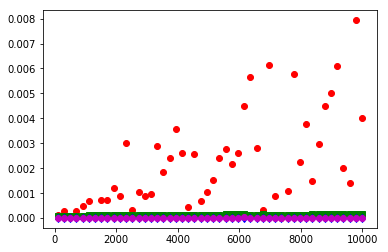

In [3]:
plt.plot(ns, ts_linsearch, 'or')
plt.plot(ns, ts_binsearch, 'sg')
plt.plot(ns, ts_setsearch, 'db')
plt.plot(ns, ts_dctsearch, 'om');

It looks like sets and dictionaries support lookup in constant time! How?!

## The *map* ADT

We will focus next on the "*map*" abstract data type (aka "associative array" or "dictionary"), which is used to associate keys (which must be unique) with values. Python's `dict` type is an implementation of the map ADT. 

Given an implementation of a map, it is trivial to implement a *set* on top of it (how?).

Here's a simple map API:

In [4]:
class MapDS:
    def __init__(self):
        self.data = []
    
    def __setitem__(self, key, value):
        for i in range(len(self.data)):
            if self.data[i][0] == key:
                self.data[i][1] = value
                return
            else:
                self.data.append([key, value])
    
    def __getitem__(self, key): #binary srarch -> O(log N)
        for k,v in self.data:
            if k == key:
                return v
            else:
                raise KeyError(str(key))
        
    
    def __contains__(self, key): #binary srarch -> O(log N)
        try:
            _ = self[key]
            return True
        except:
            return False

In [5]:
m = MapDS()
m['batman'] = 'bruce wayne'
m['superman'] = 'clark kent'
m['spiderman'] = 'peter parker'

In [6]:
m['batman'] = 'tony stark'

How do we make the leap from linear runtime complexity to constant?!

## Direct lookups via *Hashing*

Hashes (a.k.a. hash codes or hash values) are simply numerical values computed for objects.

In [7]:
hash('hello')

1525141892377621473

In [8]:
hash('batman')

-3911576532755054672

In [9]:
hash('batmen')

7549705405383518136

In [10]:
[hash(s) for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[-5429027662358978593,
 -2366297805924212740,
 1666704465765683647,
 7645840007951760429,
 -5429027662358978593,
 -2625618366117943844]

In [11]:
[i%100 for i in range(10, 1000, 40)]

[10,
 50,
 90,
 30,
 70,
 10,
 50,
 90,
 30,
 70,
 10,
 50,
 90,
 30,
 70,
 10,
 50,
 90,
 30,
 70,
 10,
 50,
 90,
 30,
 70]

In [12]:
[hash(s)%100 for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[7, 60, 47, 29, 7, 56]

## Hashtables

In [14]:
class Hashtable:
    def __init__(self, n_buckets=1000):
        self.buckets = [None] * n_buckets
        
    def __setitem__(self, key, val):
        bidx = hash(key) % len(self.buckets)
        self.buckets[bidx] = [key,val]
    
    def __getitem__(self, key):
        bidx = hash(key) % len(self.buckets)
        kv = self.buckets[bidx]
        if kv and kv[0] == key:
            return kv[1]
        else:
            raise KeyError(str(key))
        
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [15]:
ht = Hashtable(100)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [16]:
ht['batman']

'bruce wayne'

In [17]:
ht['superman']

'clark kent'

In [18]:
ht['spiderman']

'peter parker'

## On Collisions

### The "Birthday Problem"

Problem statement: Given $N$ people at a party, how likely is it that at least two people will have the same birthday?

In [19]:
def birthday_p(n_people):
    p_inv = 1
    for n in range(365, 365-n_people, -1):
        p_inv *= n / 365
    return 1 - p_inv

In [20]:
birthday_p(2)

0.002739726027397249

In [21]:
1-364/365

0.002739726027397249

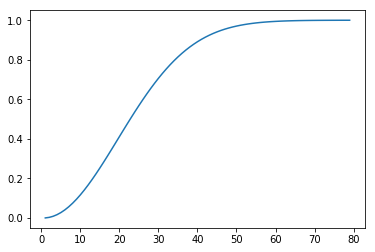

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

n_people = range(1, 80)
plt.plot(n_people, [birthday_p(n) for n in n_people])
plt.show()

### General collision statistics

Repeat the birthday problem, but with a given number of values and "buckets" that are allotted to hold them. How likely is it that two or more values will map to the same bucket?

In [23]:
def collision_p(n_values, n_buckets): #values=keys, nbuckets=denominator
    p_inv = 1
    for n in range(n_buckets, n_buckets-n_values, -1):
        p_inv *= n / n_buckets
    return 1 - p_inv

In [24]:
collision_p(23, 365) # same as birthday problem, for 23 people

0.5072972343239857

In [25]:
collision_p(10, 100)

0.37184349044470544

In [26]:
collision_p(100, 1000)

0.9940410733677595

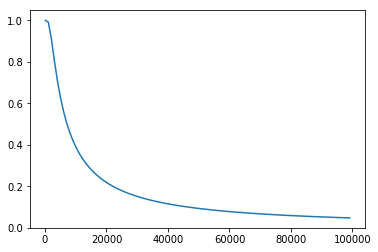

In [27]:
# keeping number of values fixed at 100, but vary number of buckets: visualize probability of collision
%matplotlib inline
import matplotlib.pyplot as plt

n_buckets = range(100, 100001, 1000)
plt.plot(n_buckets, [collision_p(100, nb) for nb in n_buckets])
plt.show()

for collisions, once u reach a certain threshold, it'll start to plateau in any direction (dec or inc)

In [28]:
def avg_num_collisions(n, b):
    """Returns the expected number of collisions for n values uniformly distributed
    over a hashtable of b buckets. Based on (fairly) elementary probability theory.
    (Pay attention in MATH 474!)"""
    return n - b + b * (1 - 1/b)**n

In [29]:
avg_num_collisions(28, 365)

1.011442040700615

In [30]:
avg_num_collisions(1000, 1000)

367.6954247709637

In [31]:
avg_num_collisions(1000, 10000)

48.32893558556316

## Dealing with Collisions

To deal with collisions in a hashtable, we simply create a "chain" of key/value pairs for each bucket where collisions occur. The chain needs to be a data structure that supports quick insertion — natural choice: the linked list!

In [34]:
class Hashtable:
    class Node:
        def __init__(self, key, val, next=None):
            self.key = key
            self.val = val
            self.next = next
            
    def __init__(self, n_buckets=1000):
        self.buckets = [None] * n_buckets
        
    def __setitem__(self, key, val):
        bidx = hash(key) % len(self.buckets)
        n = self.buckets[bidx] #n is the head of the linked list
        while n:
            if key == n.key:
                n.val = val
                return
            n = n.next
        else:
            self.buckets[bidx] = Hashtable.Node(key, val, next=self.buckets[bidx])
            #bc buckets[bidx] = n to connect the new linked list to the slot in buckets
    
    def __getitem__(self, key):
        bidx = hash(key) % len(self.buckets)
        n = self.buckets[bidx]
        while n:
            if key == n.key:
                return n.val
            n = n.next
        else:
            raise KeyError(str(key))
    
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [35]:
ht = Hashtable(1)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [37]:
ht.buckets[0].next

In [41]:
def prep_ht(size):
    ht = Hashtable(size*10)
    for x in range(size):
        ht[x] = x
    return ht

def time_ht(size):
    return timeit.timeit('ht[{}]'.format(random.randrange(size)), 
                         'import random ; from __main__ import prep_ht ;'
                         'ht = prep_ht({})'.format(size),
                         number=100)

ns = np.linspace(100, 10_000, 50, dtype=int)
ht_timings = [time_ht(n)
                for n in range(10, 10000, 100)]

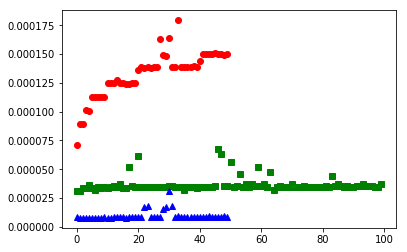

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ts_binsearch, 'ro')
plt.plot(ht_timings, 'gs')
plt.plot(ts_dctsearch, 'b^')
plt.show()

## Loose ends

### Iteration

In [44]:
class Hashtable(Hashtable):
    def __iter__(self):
        for n in self.buckets: #n stands for node
            while n:
                yield n.key
                n = n.next

In [49]:
ht = Hashtable(100)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [50]:
for k in ht:
    print(k)

spiderman
batman
superman


the order changes every time because hash%buckets changes where they are, the order shouldn't affect the way the hashtable will be used 

### Key ordering

In [51]:
ht = Hashtable()
d = {}
for x in 'apple banana cat dog elephant'.split():
    d[x[0]] = x
    ht[x[0]] = x

In [52]:
for k in d:
    print(k, '=>', d[k])

a => apple
b => banana
c => cat
d => dog
e => elephant


In [53]:
for k in ht:
    print(k, '=>', ht[k])

d => dog
b => banana
a => apple
e => elephant
c => cat


dict gives u an ordered set of keys, while the hashtable puts it at random
+ python puts it in order of insertion
+ dict orders key in order of insertion (good for debugging diagnostics)
+ ht is a faster mapping structure bc it doesnt change the runtime complexity but still rnadomly inserts nodes in the linked list

### "Load factor" and Rehashing

It doesn't often make sense to start with a large number of buckets, unless we know in advance that the number of keys is going to be vast — also, the user of the hashtable would typically prefer to not be bothered with implementation details (i.e., bucket count) when using the data structure.

Instead: start with a relatively small number of buckets, and if the ratio of keys to the number of buckets (known as the **load factor**) is above some desired threshold — which we can determine using collision probabilities — we can dynamically increase the number of buckets. This requires, however, that we *rehash* all keys and potentially move them into new buckets (since the `hash(key) % num_buckets` mapping will likely be different with more buckets).

### Other APIs

- FIXED `__setitem__` (to update value for existing key)
- `__delitem__`
- `keys` & `values` (return iterators for keys and values)
- `setdefault`

## Runtime analysis & Discussion

For a hashtable with $N$ key/value entries, we have the following WORST-CASE RUNTIME COMPLEXITY:

- Insertion: $O(N)$
    + when there are possible collisions
- Lookup: $O(N)$
- Deletion: $O(N)$
    + lookup plus deletion, but lookup is O(1) n deletion is O(N)

## Vocabulary list

- hashtable
- hashing and hashes
- collision
- hash buckets & chains
- birthday problem
- load factor
- rehashing

---

## Addendum: On *Hashability*

Remember: *a given object must always hash to the same value*. This is required so that we can always map the object to the same hash bucket.

Hashcodes for collections of objects are usually computed from the hashcodes of its contents, e.g., the hash of a tuple is a function of the hashes of the objects in said tuple:

In [ ]:
hash(('two', 'strings'))

This is useful. It allows us to use a tuple, for instance, as a key for a hashtable.

However, if the collection of objects is *mutable* — i.e., we can alter its contents — this means that we can potentially change its hashcode.`

If we were to use such a collection as a key in a hashtable, and alter the collection after it's been assigned to a particular bucket, this leads to a serious problem: the collection may now be in the wrong bucket (as it was assigned to a bucket based on its original hashcode)!

For this reason, only immutable types are, by default, hashable in Python. So while we can use integers, strings, and tuples as keys in dictionaries, lists (which are mutable) cannot be used. Indeed, Python marks built-in mutable types as "unhashable", e.g.,

In [ ]:
hash([1, 2, 3])

That said, Python does support hashing on instances of custom classes (which are mutable). This is because the default hash function implementation does not rely on the contents of instances of custom classes. E.g.,

In [ ]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname

In [ ]:
s = Student('John', 'Doe')
hash(s)

In [ ]:
s.fname = 'Jane'
hash(s) # same as before mutation

We can change the default behavior by providing our own hash function in `__hash__`, e.g.,

In [ ]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname
        
    def __hash__(self):
        return hash(self.fname) + hash(self.lname)

In [ ]:
s = Student('John', 'Doe')
hash(s)

In [ ]:
s.fname = 'Jane'
hash(s)

But be careful: instances of this class are no longer suitable for use as keys in hashtables (or dictionaries), if you intend to mutate them after using them as keys!